In [1]:
import grblas as gb
import numpy as np
from grblas import Matrix, Vector, Recorder, semiring, unary, monoid, op, binary
from grblas.io import draw

In [2]:
data = [
    [3,0,3,5,6,0,6,1,6,2,4,1],
    [0,1,2,2,2,3,3,4,4,5,5,6],
    [3,2,3,1,5,3,7,8,3,1,7,4]
]
A = Matrix.from_values(*data, name='A_0')
v = Vector.from_values([1], [0], dtype=A.dtype, size=A.nrows)

# GraphBLAS in 10 seconds

- [GraphBLAS](https://graphblas.github.io/) is a **fast** sparse linear algebra library
- It is designed for **graph algorithms** in the language of **linear algebra**
  - **Powerful** enough for other use cases!
- Use from Python with [**`grblas`**](https://github.com/metagraph-dev/grblas) (our library) and `pygraphblas`

![Graph adjacency matrix](https://graphblas.github.io/AdjacencyMatrixBFS.png)

*Presenter: [Erik Welch](https://github.com/eriknw/) (Anaconda)*

# GraphBLAS in 30 seconds...
- This is an **adjacency matrix** with *edge weights*
- Each **row** shows the **out-edges** of a node
- Each **column** shows the **in-edges** of a node

In [3]:
A  # click on my output!

"A_0"          nvals  nrows  ncols  dtype
grblas.Matrix     12      7      7  INT64
-----------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

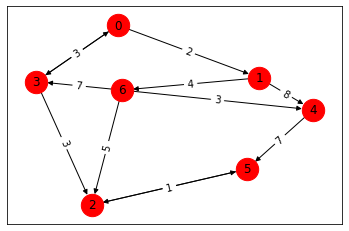

In [4]:
draw(A)

## One step of **single-source-shortest-path (SSSP)**

In [5]:
v  # This is our "frontier"; we start from node 1

"v_0"          nvals  size  dtype
grblas.Vector      1     7  INT64
---------------------------------
 0  1 2 3 4 5 6
    0

In [6]:
semiring.min_plus(A.T @ v).new(name='baby_step')  # One step

"baby_step"    nvals  size  dtype
grblas.Vector      2     7  INT64
---------------------------------
 0 1 2 3  4 5  6
          8    4

- *Wait, what just happened?*
- Why did we need `.new()`?
- What's a <span style="color:purple"><b>Semiring</b></span>?

### Without `.new()`, this is a **lazy expression**

In [7]:
semiring.min_plus(A.T @ v)  # Click me too!

grblas.VectorExpression                      size  dtype
A_0.T.mxv(v_0, op=semiring.min_plus[INT64])     7  INT64

Do expr.new() or other << expr to calculate the expression.

In [8]:
print(13*'\n')

## Side note: most things in `grblas` are **lazy**
- `A.T` is **lazy**; it will set the "transpose descriptor"
- `A.T @ v` is **lazy**; we can still specify the <span style="color:purple"><b>Semiring</b></span>
- `semiring.min_plus(A.T @ v)` is **lazy**; there is much we can still do!
- and more!

### This allows `grblas` to match **math notation** used by GraphBLAS
- *Trust us:* this may be **weird**, but **it's worth it**!
- Take a peek [here](https://arxiv.org/pdf/2104.01661.pdf#page=4) and [here](https://raw.githubusercontent.com/DrTimothyAldenDavis/GraphBLAS/stable/Doc/GraphBLAS_UserGuide.pdf#page=28)
- Advanced topics: **masks**, **accumulators**, **replace**, **non-blocking**

# <span style="color:blue">BinaryOps</span>, <span style="color:red">Monoids</span>, and <span style="color:purple">Semirings</span>... oh my!
- NumPy **matrix multiply** `A @ b` supports **one** <span style="color:purple"><b>Semiring</b></span>: <tt style="color:red">plus</tt><tt>-</tt><tt style="color:blue">times</tt>
  - This is standard matrix multiply
  - <tt style="color:red">plus</tt> is the <span style="color:red"><b>Monoid</b></span> (associative, commutative, has identity)
  - <tt style="color:blue">times</tt> is the <span style="color:blue"><b>BinaryOp</b></span> (no constraints)
- GraphBLAS matrix multiply supports **arbitrary** <span style="color:purple"><b>Semirings</b></span>!
  - For example, <tt style="color:red">min</tt><tt>-</tt><tt style="color:blue">plus</tt> is used to calculate **shortest path**
  - <tt style="color:blue">plus</tt> <span style="color:blue"><b>BinaryOp</b></span> computes path lengths
  - <tt style="color:red">min</tt> <span style="color:red"><b>Monoid</b></span> determines the shortest path length
  - **Missing** elements are **ignored** (not assumed to be `0`)
- *Am I moving too fast?*  **That's okay**.  Keep going...

# GraphBLAS in 2 minutes
- GraphBLAS is actually a **C API specification** ([pdf](http://people.eecs.berkeley.edu/~aydin/GraphBLAS_API_C_v13.pdf))
- [**SuiteSparse:GraphBLAS**](https://github.com/DrTimothyAldenDavis/GraphBLAS) by [Tim Davis](https://twitter.com/docsparse) is the main **implementation** ([pdf](https://github.com/DrTimothyAldenDavis/GraphBLAS/raw/stable/Doc/GraphBLAS_UserGuide.pdf))
- *Have I mentioned that SuiteSparse:GraphBLAS is __FAST__?*

## Also, graph computation is **hard**
- **Irregular** access patterns -> **poor locality** -> cache misses and cache invalidation
- Difficult to **scale** and **parallelize**
- Difficult to write optimized, readable, portable code

**Intuition about NumPy and dense linear algebra is of little help!**

# GraphBLAS **does not** specify memory layout
- There are many, many sparse matrix formats
  - See: https://docs.scipy.org/doc/scipy/reference/sparse.html
- GraphBLAS objects are **opaque**; the internals are hidden
- GraphBLAS operations can be **non-blocking** and **lazy**
  - Implementations may **delay** computation to allow for **optimizations**
- **End result:** users *think* and *program* in terms of **linear algebra**, not data structures
- But, SuiteSparse:GraphBLAS and `grblas` don't hide the format
  - We support **zero-copy** to and from **common formats** such as CSR and CSC
  - The user get and set the formats they want to use

# Single-source-shortest-path (SSSP) cont'd

- From a starting node, what is the shortest distance to get to any node?
- Recall our data:

In [9]:
A

"A_0"          nvals  nrows  ncols  dtype
grblas.Matrix     12      7      7  INT64
-----------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

In [10]:
v

"v_0"          nvals  size  dtype
grblas.Vector      1     7  INT64
---------------------------------
 0  1 2 3 4 5 6
    0

## Step 1

- We **accumulate** the result of the matrix multiplication into `v` using `min`
- This keeps around the **previous best path** to that node
  - In this case, the cost to go from node 1 to itself is **0**

In [11]:
v(binary.min) << semiring.min_plus(A.T @ v)
v

"v_0"          nvals  size  dtype
grblas.Vector      3     7  INT64
---------------------------------
 0  1 2 3  4 5  6
    0      8    4

# Step 2

- Expressions of the form `left << right` is **sugar** for `left.update(right)`
- It is used to **assign into** an existing data structure
- Things we can put on the left:
  - **Accumulators** such as `binary.min`
  - **Masks**, which indicate whether or not to save to a location
  - **Assign** indices (using square brackets)
  - **replace**, which we won't cover here

In [12]:
v(binary.min) << semiring.min_plus(A.T @ v)
v

"v_0"          nvals  size  dtype
grblas.Vector      6     7  INT64
---------------------------------
 0  1  2   3  4   5  6
    0  9  11  7  15  4

# Step 3 and 4

- No change between step 3 and 4, so we're done!

In [13]:
v(binary.min) << semiring.min_plus(A.T @ v)
v

"v_0"          nvals  size  dtype
grblas.Vector      7     7  INT64
---------------------------------
   0  1  2   3  4   5  6
  14  0  9  11  7  10  4

In [14]:
v(binary.min) << semiring.min_plus(A.T @ v)
v

"v_0"          nvals  size  dtype
grblas.Vector      7     7  INT64
---------------------------------
   0  1  2   3  4   5  6
  14  0  9  11  7  10  4

# Another look

In [15]:
v

"v_0"          nvals  size  dtype
grblas.Vector      7     7  INT64
---------------------------------
   0  1  2   3  4   5  6
  14  0  9  11  7  10  4

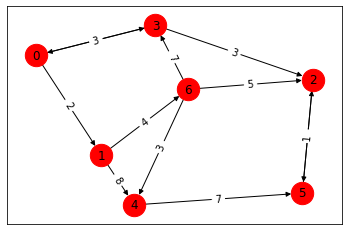

In [16]:
draw(A)

# What does the C call look like?
- Use **Recorder** to show GraphBLAS calls

In [17]:
with Recorder() as rec:
    v(binary.min) << semiring.min_plus(A.T @ v)
print(rec)

grblas.Recorder (not recording)
-------------------------------
  GrB_mxv(v_0, NULL, GrB_MIN_INT64, GrB_MIN_PLUS_SEMIRING_INT64, A_0, v_0, GrB_DESC_T0);


In [18]:
with Recorder() as rec:
    w = A[0, :].new(mask=v.S, name='w')
print(rec)

grblas.Recorder (not recording)
-------------------------------
  GrB_Vector_new(&w, GrB_INT64, 7);
  GrB_Col_extract(w, v_0, NULL, A_0, GrB_ALL, 7, 0, GrB_DESC_ST0);


# 20 more seconds...

- **Graph computation is hard**
  - Irregular access patterns -> poor locality -> cache misses and cache invalidation
  - Difficult to scale and parallelize
  - Difficult to write optimized, readable, portable code
- **GraphBLAS FTW!**
  - TODO

# 10 more seconds...

TODO: Introduce matrix multiply with arbitrary semirings

# `grblas` is like math notation

Which requires novel Python syntax

# GraphBLAS in 2 minutes

Dive deeper into examples, syntax, features, etc.